# Task 2: DG with IRM Variants

## Part 2

## Preparing RMNIST Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data import Subset


# Function to Create Rotated MNIST Environments with Limited Samples
def create_rmnist_environment(root, rotations, batch_size, shuffle=True):
    datasets_dict = {}

    # Load the full MNIST dataset
    full_dataset = datasets.MNIST(root=root, train=True, download=True)

    # Determine the number of samples to use (half of the full dataset)
    num_samples = len(full_dataset) // 4
    indices = np.random.choice(len(full_dataset), num_samples, replace=False)  # Randomly select indices

    # Create a subset of the MNIST dataset
    subset_dataset = Subset(full_dataset, indices)

    for angle in rotations:
        # Apply rotation and other transformations
        transform = transforms.Compose([
            transforms.RandomRotation([angle, angle]),
            transforms.Grayscale(num_output_channels=3),  # Convert 1 channel to 3 channels
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

        # Wrap the subset dataset with the transform
        rotated_dataset = datasets.MNIST(
            root=root, train=True, transform=transform, download=False
        )
        rotated_dataset.data = subset_dataset.dataset.data[subset_dataset.indices]
        rotated_dataset.targets = subset_dataset.dataset.targets[subset_dataset.indices]

        # Create a DataLoader for the rotated subset
        datasets_dict[angle] = DataLoader(
            rotated_dataset, batch_size=batch_size, shuffle=shuffle
        )

    return datasets_dict

In [2]:
# Create RMNIST Environments
train_rotations = [15, 30, 45, 60, 75]  # Training rotations
test_rotation = [0]  # Testing rotation
root = './rmnist'

batch_size = 64

train_envs = create_rmnist_environment(root, train_rotations, batch_size)
test_env = create_rmnist_environment(root, test_rotation, batch_size, shuffle=False)[0]

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 59157917.63it/s]


Extracting ./rmnist/MNIST/raw/train-images-idx3-ubyte.gz to ./rmnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1552663.41it/s]

Extracting ./rmnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./rmnist/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13705608.96it/s]


Extracting ./rmnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./rmnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4111033.40it/s]

Extracting ./rmnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./rmnist/MNIST/raw



In [3]:
# Hyperparameters
batch_size = 64
epochs = 3
lr = 0.001
num_classes = 10

## IRM Basic

IRM Basic Loss and Model

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the IRM Loss
class IRMLoss(nn.Module):
    def __init__(self, lambda_penalty):
        super(IRMLoss, self).__init__()
        self.lambda_penalty = lambda_penalty

    def forward(self, logits, labels, feature_extractor, classifier):
        # Standard Cross-Entropy Loss
        ce_loss = nn.CrossEntropyLoss()(logits, labels)

        # IRM penalty (gradient norm squared)
        dummy_w = torch.ones((1,), requires_grad=True, device=logits.device)
        penalty = torch.autograd.grad(
            outputs=(dummy_w * logits).sum(),
            inputs=list(feature_extractor.parameters()),
            create_graph=True,
            retain_graph=True,
        )
        penalty_norm = torch.norm(torch.cat([p.view(-1) for p in penalty])) ** 2

        # Total Loss
        total_loss = ce_loss + self.lambda_penalty * penalty_norm
        return total_loss


# Define the IRM Basic Model
class IRMModel(nn.Module):
    def __init__(self, num_classes):
        super(IRMModel, self).__init__()
        # Use ResNet-50 as the feature extractor
        self.feature_extractor = models.resnet50(pretrained=True)
        self.feature_extractor.fc = nn.Identity()  # Remove the fully connected layer

        # Classifier head
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits

Training and Evaluation Functions

In [11]:
def train_irm(model, train_envs, optimizer, irm_loss_fn, device):
    model.train()
    total_loss = 0.0  # Overall loss (averaged across all rotations)
    total_samples = 0  # Overall sample count
    rotation_accuracies = {}  # Accuracy per rotation

    for rotation, dataloader in train_envs.items():
        correct = 0
        rotation_samples = 0
        rotation_loss = 0.0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            logits = model(images)

            # Compute IRM loss
            loss = irm_loss_fn(logits, labels, model.feature_extractor, model.classifier)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate metrics for this rotation
            batch_size = images.size(0)
            rotation_loss += loss.item() * batch_size
            total_loss += loss.item() * batch_size  # Add to overall loss
            total_samples += batch_size  # Increment overall sample count

            _, predicted = logits.max(1)
            correct += (predicted == labels).sum().item()
            rotation_samples += batch_size

        # Calculate and store accuracy for this rotation
        rotation_accuracies[rotation] = 100.0 * correct / rotation_samples

    avg_loss = total_loss / total_samples  # Compute average loss over all rotations
    return avg_loss, rotation_accuracies


def evaluate_irm(model, dataloader, device):
    model.eval()
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            logits = model(images)
            _, predicted = logits.max(1)
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = 100.0 * correct / total_samples

    return accuracy

In [12]:
# Hyperparameters
lambda_penalty = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model, Optimizer, and Loss
model = IRMModel(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = IRMLoss(lambda_penalty)

# Initialize lists for logging
train_losses = []
domain_accuracies_per_epoch = {}
ood_accuracies = []

# Training Loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    avg_loss, rotation_accuracies = train_irm(model, train_envs, optimizer, criterion, device)
    train_losses.append(avg_loss)
    print(f"Average Loss: {avg_loss:.4f}")

    domain_accuracies_per_epoch[epoch + 1] = rotation_accuracies  # Log accuracies per domain
    for domain, accuracy in rotation_accuracies.items():
        print(f"Domain {domain} - Accuracy: {accuracy:.2f}%")

    # Evaluate and log OOD accuracy
    ood_accuracy = evaluate_irm(model, test_env, device)
    ood_accuracies.append(ood_accuracy)
    print(f"OOD Accuracy on Target Domain: {ood_accuracy:.2f}%")

Epoch 1/3
Average Loss: 54549.7745
Domain 15 - Accuracy: 10.40%
Domain 30 - Accuracy: 16.35%
Domain 45 - Accuracy: 21.16%
Domain 60 - Accuracy: 22.33%
Domain 75 - Accuracy: 23.45%
OOD Accuracy on Target Domain: 12.48%
Epoch 2/3
Average Loss: 301.1858
Domain 15 - Accuracy: 24.01%
Domain 30 - Accuracy: 31.35%
Domain 45 - Accuracy: 28.91%
Domain 60 - Accuracy: 27.18%
Domain 75 - Accuracy: 26.71%
OOD Accuracy on Target Domain: 17.23%
Epoch 3/3
Average Loss: 18.0779
Domain 15 - Accuracy: 26.83%
Domain 30 - Accuracy: 34.21%
Domain 45 - Accuracy: 31.11%
Domain 60 - Accuracy: 28.22%
Domain 75 - Accuracy: 27.45%
OOD Accuracy on Target Domain: 17.51%


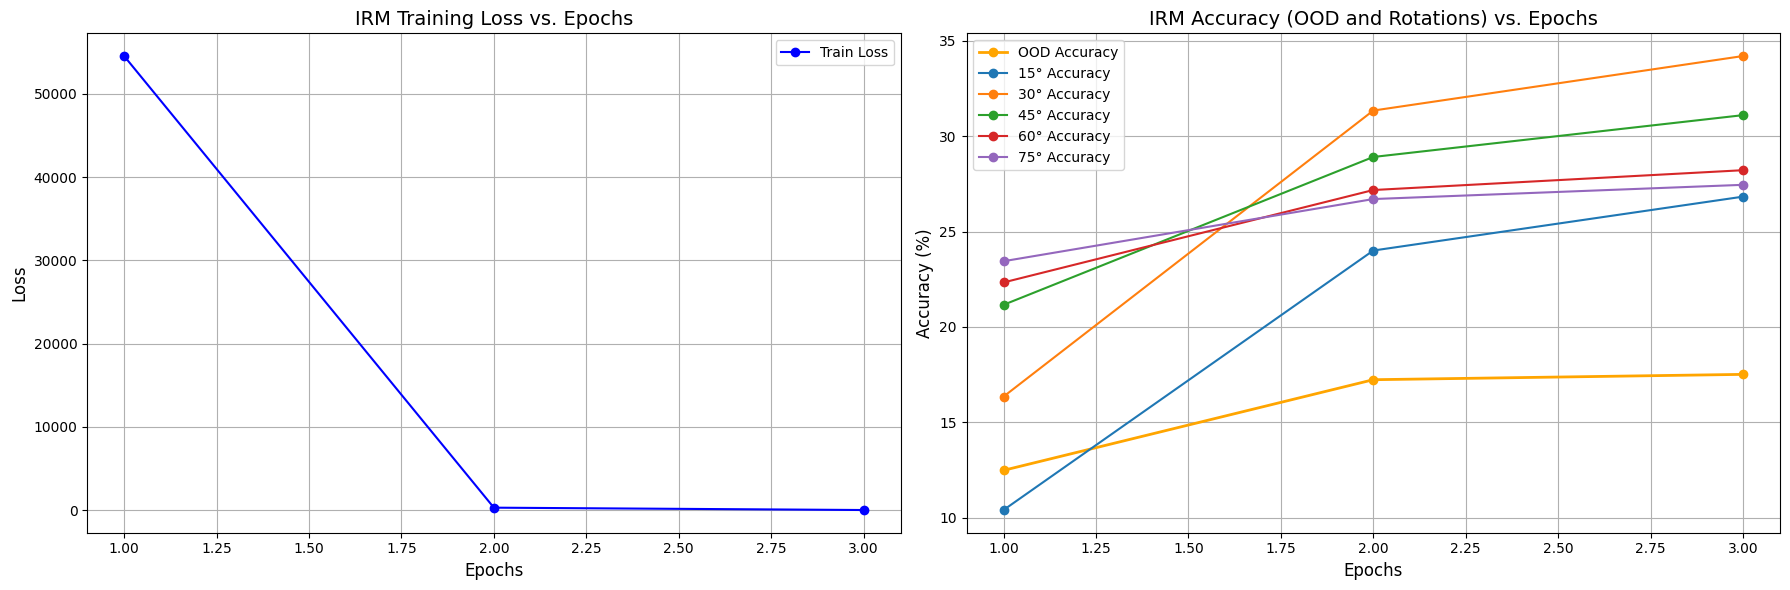

In [13]:
# Create a single row with two subplots: Loss on the left, Accuracy on the right
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Training Loss on the first subplot
axes[0].plot(range(1, epochs + 1), train_losses, marker='o', label='Train Loss', color='blue')
axes[0].set_title('IRM Training Loss vs. Epochs', fontsize=14)
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].grid(True)
axes[0].legend(fontsize=10)

# Prepare Training Accuracy Per Rotation Data
train_accs_per_rotation = {rotation: [] for rotation in train_envs.keys()}
for epoch, accuracies in domain_accuracies_per_epoch.items():
    for rotation, accuracy in accuracies.items():
        train_accs_per_rotation[rotation].append(accuracy)

# Plot OOD Accuracy and Training Accuracy Per Rotation on the second subplot
axes[1].plot(range(1, epochs + 1), ood_accuracies, marker='o', label='OOD Accuracy', color='orange', linewidth=2)

for rotation, accuracies in train_accs_per_rotation.items():
    axes[1].plot(range(1, epochs + 1), accuracies, marker='o', label=f'{rotation}° Accuracy')

axes[1].set_title('IRM Accuracy (OOD and Rotations) vs. Epochs', fontsize=14)
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].grid(True)
axes[1].legend(fontsize=10)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

## IB-IRM

Defining the Model and the Loss


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# IB-IRM Loss Class
class IBIRMLoss(nn.Module):
    def __init__(self, lambda_penalty, gamma_variance):
        super(IBIRMLoss, self).__init__()
        self.lambda_penalty = lambda_penalty
        self.gamma_variance = gamma_variance

    def forward(self, logits, labels, features, feature_extractor):
        # Cross-Entropy Loss
        ce_loss = nn.CrossEntropyLoss()(logits, labels)

        # IRM Penalty (Gradient Norm Squared)
        dummy_w = torch.ones((1,), requires_grad=True, device=logits.device)
        penalty = torch.autograd.grad(
            outputs=(dummy_w * logits).sum(),
            inputs=list(feature_extractor.parameters()),
            create_graph=True,
            retain_graph=True,
        )
        penalty_norm = torch.norm(torch.cat([p.view(-1) for p in penalty])) ** 2

        # Variance Regularization Term
        mean_features = features.mean(dim=0)  # Mean of feature representations
        variance = ((features - mean_features) ** 2).sum(dim=1).mean()

        # Total Loss
        total_loss = ce_loss + self.lambda_penalty * penalty_norm + self.gamma_variance * variance
        return total_loss, penalty_norm, variance


# IB-IRM Model
class IBIRMModel(nn.Module):
    def __init__(self, num_classes):
        super(IBIRMModel, self).__init__()
        # Use ResNet-50 as the feature extractor
        self.feature_extractor = models.resnet50(pretrained=True)
        self.feature_extractor.fc = nn.Identity()  # Remove the default fully connected layer

        # Classifier head
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits, features

Train and Evaluate Functions

In [7]:
def train_ibirm(model, train_envs, optimizer, criterion, device):
    model.train()
    total_loss = 0.0  # Overall loss (averaged across all domains)
    total_samples = 0  # Overall sample count
    domain_accuracies = {}  # Accuracy per domain (rotation)

    for domain, dataloader in train_envs.items():
        correct = 0
        domain_samples = 0
        domain_loss = 0.0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            logits, features = model(images)

            # Compute IB-IRM loss
            loss, penalty_norm, variance = criterion(logits, labels, features, model.feature_extractor)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate metrics for this domain
            batch_size = images.size(0)
            domain_loss += loss.item() * batch_size
            total_loss += loss.item() * batch_size  # Add to overall loss
            total_samples += batch_size  # Increment overall sample count

            _, predicted = logits.max(1)
            correct += (predicted == labels).sum().item()
            domain_samples += batch_size

        # Calculate and store accuracy for this domain
        domain_accuracies[domain] = 100.0 * correct / domain_samples

    avg_loss = total_loss / total_samples  # Compute average loss over all domains
    return avg_loss, domain_accuracies

def evaluate_ibirm(model, dataloader, device):
    model.eval()
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            logits, _ = model(images)
            _, predicted = logits.max(1)

            # Accumulate metrics
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = 100.0 * correct / total_samples
    return accuracy

In [8]:
# Hyperparameters
lambda_penalty = 0.5
gamma_variance = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model, Optimizer, and Loss
model = IBIRMModel(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = IBIRMLoss(lambda_penalty, gamma_variance)

# Training Loop
train_losses = []
ood_accuracies = []
domain_accuracies_per_epoch = {}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Train with IB-IRM
    train_loss, domain_accuracies = train_ibirm(model, train_envs, optimizer, criterion, device)
    train_losses.append(train_loss)  # Log train loss
    domain_accuracies_per_epoch[epoch + 1] = domain_accuracies  # Log accuracies per domain

    print(f"Train Loss: {train_loss:.4f}")
    for domain, accuracy in domain_accuracies.items():
        print(f"Domain {domain} - Accuracy: {accuracy:.2f}%")

    # Evaluate on OOD Target Domain
    ood_accuracy = evaluate_ibirm(model, test_env, device)
    ood_accuracies.append(ood_accuracy)  # Log OOD accuracy
    print(f"OOD Accuracy on Target Domain: {ood_accuracy:.2f}%")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s] 


Epoch 1/3
Train Loss: 58642.7055
Domain 15 - Accuracy: 14.34%
Domain 30 - Accuracy: 27.92%
Domain 45 - Accuracy: 33.19%
Domain 60 - Accuracy: 30.38%
Domain 75 - Accuracy: 27.46%
OOD Accuracy on Target Domain: 25.16%
Epoch 2/3
Train Loss: 807.0363
Domain 15 - Accuracy: 43.12%
Domain 30 - Accuracy: 44.35%
Domain 45 - Accuracy: 41.33%
Domain 60 - Accuracy: 34.11%
Domain 75 - Accuracy: 30.25%
OOD Accuracy on Target Domain: 35.47%
Epoch 3/3
Train Loss: 141.7022
Domain 15 - Accuracy: 47.15%
Domain 30 - Accuracy: 47.30%
Domain 45 - Accuracy: 42.61%
Domain 60 - Accuracy: 35.95%
Domain 75 - Accuracy: 32.35%
OOD Accuracy on Target Domain: 35.57%


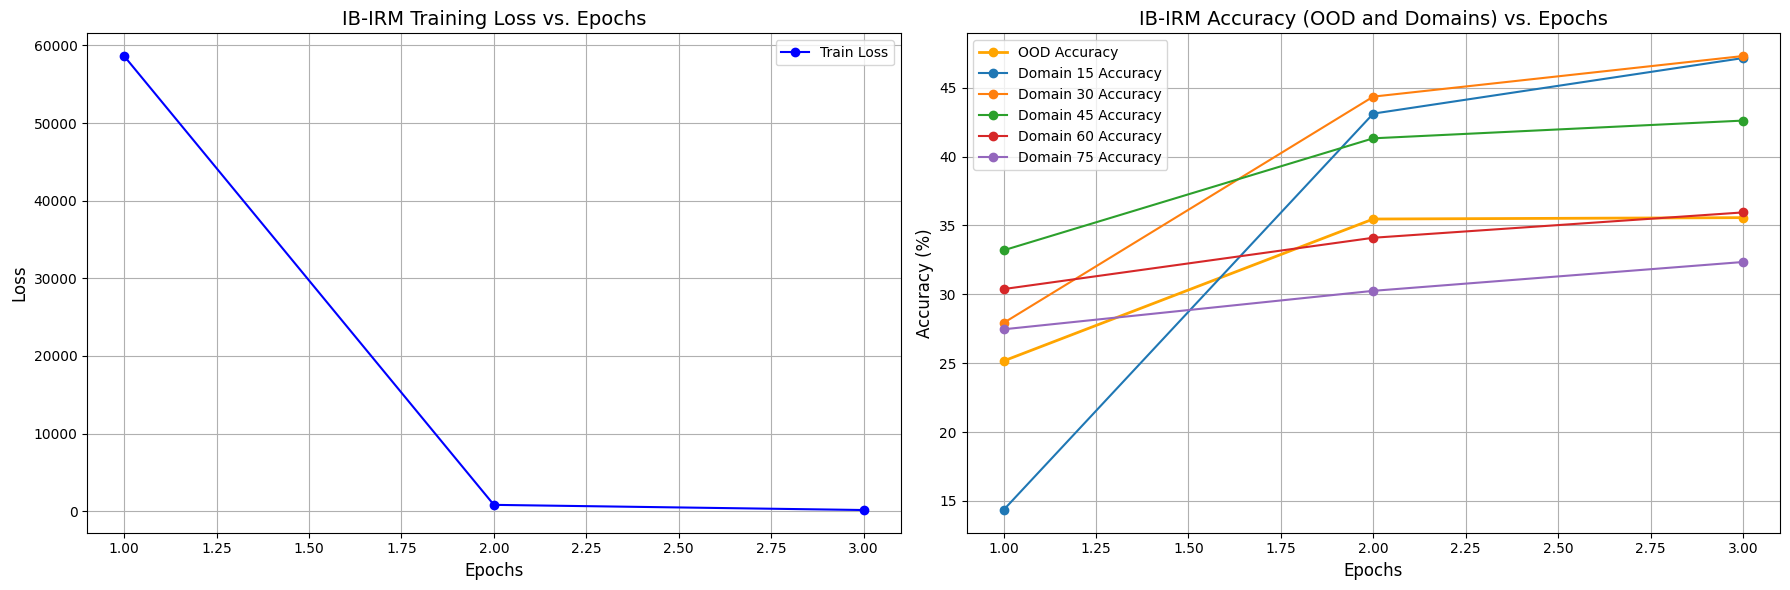

In [9]:
# Prepare Training Accuracy Per Domain Data
train_accs_per_domain = {domain: [] for domain in train_envs.keys()}
for epoch, accuracies in domain_accuracies_per_epoch.items():
    for domain, accuracy in accuracies.items():
        train_accs_per_domain[domain].append(accuracy)

# Create a single row with two subplots: Loss on the left, Accuracy on the right
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Training Loss on the first subplot
axes[0].plot(range(1, epochs + 1), train_losses, marker='o', label='Train Loss', color='blue')
axes[0].set_title('IB-IRM Training Loss vs. Epochs', fontsize=14)
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].grid(True)
axes[0].legend(fontsize=10)

# Plot OOD Accuracy and Training Accuracy Per Domain on the second subplot
axes[1].plot(range(1, epochs + 1), ood_accuracies, marker='o', label='OOD Accuracy', color='orange', linewidth=2)

for domain, accuracies in train_accs_per_domain.items():
    axes[1].plot(range(1, epochs + 1), accuracies, marker='o', label=f'Domain {domain} Accuracy')

axes[1].set_title('IB-IRM Accuracy (OOD and Domains) vs. Epochs', fontsize=14)
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].grid(True)
axes[1].legend(fontsize=10)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

## PAIR: ParetoIRM

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# PAIR Loss Class
class PAIRLoss(nn.Module):
    def __init__(self, lambda_penalty, gamma_variance, w1=1.0, w2=1.0, w3=1.0):
        super(PAIRLoss, self).__init__()
        self.lambda_penalty = lambda_penalty
        self.gamma_variance = gamma_variance
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3

    def forward(self, logits, labels, features, feature_extractor):
        # ERM Loss (Cross-Entropy)
        erm_loss = nn.CrossEntropyLoss()(logits, labels)

        # IRM Penalty (Gradient Norm Squared)
        dummy_w = torch.ones((1,), requires_grad=True, device=logits.device)
        irm_penalty = torch.autograd.grad(
            outputs=(dummy_w * logits).sum(),
            inputs=list(feature_extractor.parameters()),
            create_graph=True,
            retain_graph=True,
        )
        irm_penalty_norm = torch.norm(torch.cat([p.view(-1) for p in irm_penalty])) ** 2

        # Variance Regularization
        mean_features = features.mean(dim=0)  # Mean of feature representations
        variance = ((features - mean_features) ** 2).sum(dim=1).mean()

        # Weighted Sum of Losses
        total_loss = (
            self.w1 * erm_loss +
            self.w2 * self.lambda_penalty * irm_penalty_norm +
            self.w3 * self.gamma_variance * variance
        )
        return total_loss, erm_loss, irm_penalty_norm, variance


# PAIR Model
class PAIRModel(nn.Module):
    def __init__(self, num_classes):
        super(PAIRModel, self).__init__()
        # Use ResNet-50 as the feature extractor
        self.feature_extractor = models.resnet50(pretrained=True)
        self.feature_extractor.fc = nn.Identity()  # Remove the default fully connected layer

        # Classifier head
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits, features

In [15]:
def train_pair(model, train_envs, optimizer, criterion, device):
    model.train()
    total_loss = 0.0  # Overall loss (averaged across all domains)
    total_samples = 0  # Overall sample count
    domain_accuracies = {}  # Accuracy per domain (rotation)

    for domain, dataloader in train_envs.items():
        correct = 0
        domain_samples = 0
        domain_loss = 0.0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            logits, features = model(images)

            # Compute PAIR loss
            loss, erm_loss, irm_penalty_norm, variance = criterion(logits, labels, features, model.feature_extractor)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate metrics for this domain
            batch_size = images.size(0)
            domain_loss += loss.item() * batch_size
            total_loss += loss.item() * batch_size  # Add to overall loss
            total_samples += batch_size  # Increment overall sample count

            _, predicted = logits.max(1)
            correct += (predicted == labels).sum().item()
            domain_samples += batch_size

        # Calculate and store accuracy for this domain
        domain_accuracies[domain] = 100.0 * correct / domain_samples

    avg_loss = total_loss / total_samples  # Compute average loss over all domains
    return avg_loss, domain_accuracies


def evaluate_pair(model, loader, device):
    model.eval()
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            logits, _ = model(images)
            _, predicted = logits.max(1)

            # Accumulate metrics
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = 100.0 * correct / total_samples
    return accuracy

In [16]:
# Hyperparameters
lambda_penalty = 0.5
gamma_variance = 0.001
w1 = 0.1  # Keep ERM weight stable
w2 = 1.0  # Reduce IRM penalty weight
w3 = 0.01  # Significantly reduce variance regularization weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model, Optimizer, and Loss
model = PAIRModel(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = PAIRLoss(lambda_penalty, gamma_variance, w1, w2, w3)

# Training and Evaluation
train_losses = []
ood_accuracies = []
domain_accuracies_per_epoch = {}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Train
    train_loss, domain_accuracies = train_pair(model, train_envs, optimizer, criterion, device)
    train_losses.append(train_loss)
    domain_accuracies_per_epoch[epoch + 1] = domain_accuracies

    print(f"Train Loss: {train_loss:.4f}")
    for domain, accuracy in domain_accuracies.items():
        print(f"Domain {domain} - Accuracy: {accuracy:.2f}%")

    # Evaluate
    ood_accuracy = evaluate_pair(model, test_env, device)
    ood_accuracies.append(ood_accuracy)
    print(f"OOD Accuracy: {ood_accuracy:.2f}%")

Epoch 1/3
Train Loss: 97750.2751
Domain 15 - Accuracy: 14.85%
Domain 30 - Accuracy: 26.47%
Domain 45 - Accuracy: 26.23%
Domain 60 - Accuracy: 22.09%
Domain 75 - Accuracy: 23.09%
OOD Accuracy: 13.27%
Epoch 2/3
Train Loss: 2706.4957
Domain 15 - Accuracy: 34.31%
Domain 30 - Accuracy: 36.25%
Domain 45 - Accuracy: 33.00%
Domain 60 - Accuracy: 27.28%
Domain 75 - Accuracy: 24.97%
OOD Accuracy: 13.98%
Epoch 3/3
Train Loss: 428.4884
Domain 15 - Accuracy: 38.19%
Domain 30 - Accuracy: 38.55%
Domain 45 - Accuracy: 33.85%
Domain 60 - Accuracy: 28.01%
Domain 75 - Accuracy: 25.01%
OOD Accuracy: 14.06%


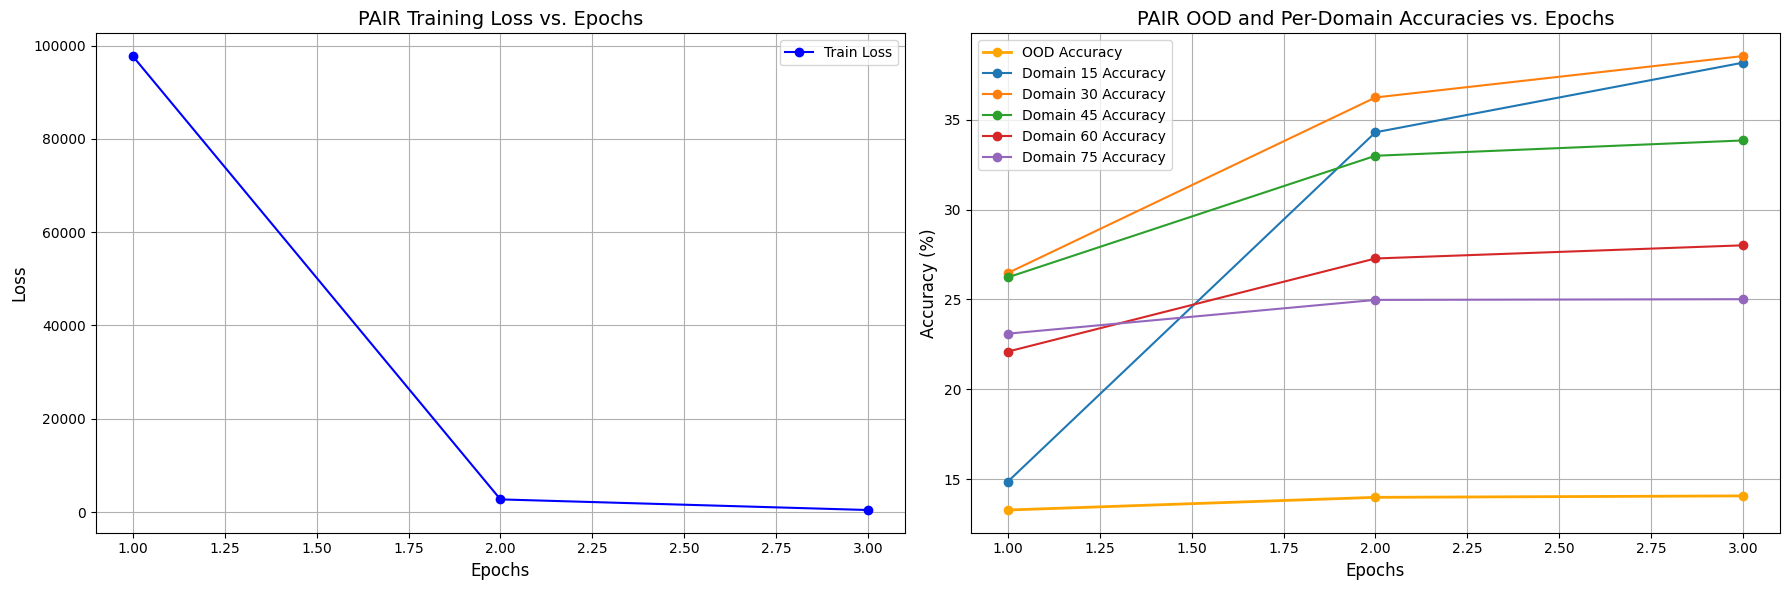

In [17]:
# Prepare Training Accuracy Per Domain Data
train_accs_per_domain = {domain: [] for domain in train_envs.keys()}
for epoch, accuracies in domain_accuracies_per_epoch.items():
    for domain, accuracy in accuracies.items():
        train_accs_per_domain[domain].append(accuracy)

# Create Subplots: Loss on the left, Accuracy (OOD and per-domain) on the right
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Training Loss on the first subplot
axes[0].plot(range(1, epochs + 1), train_losses, marker='o', label='Train Loss', color='blue')
axes[0].set_title('PAIR Training Loss vs. Epochs', fontsize=14)
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].grid(True)
axes[0].legend(fontsize=10)

# Plot OOD Accuracy and Training Accuracy Per Domain on the second subplot
axes[1].plot(range(1, epochs + 1), ood_accuracies, marker='o', label='OOD Accuracy', color='orange', linewidth=2)

for domain, accuracies in train_accs_per_domain.items():
    axes[1].plot(range(1, epochs + 1), accuracies, marker='o', label=f'Domain {domain} Accuracy')

axes[1].set_title('PAIR OOD and Per-Domain Accuracies vs. Epochs', fontsize=14)
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].grid(True)
axes[1].legend(fontsize=10)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

## IID vs OOD Visualisation

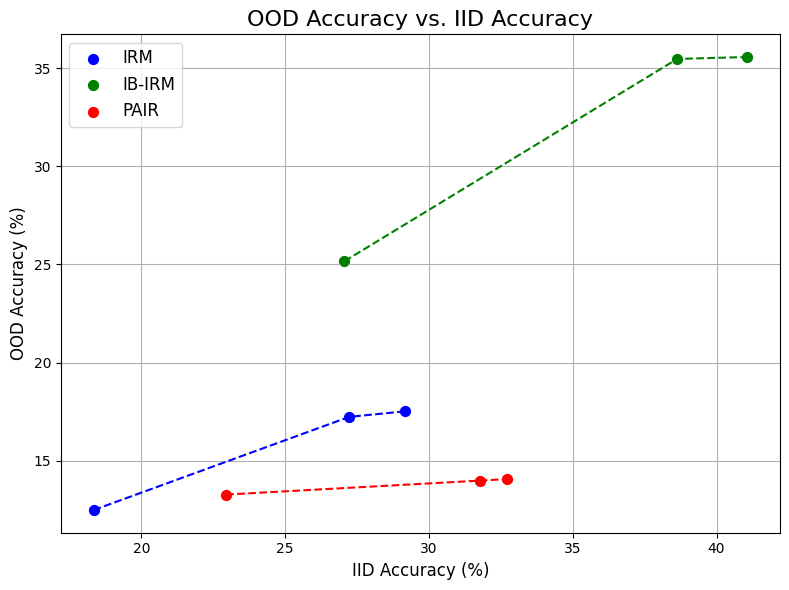

In [21]:
import matplotlib.pyplot as plt

# Data for Basic IRM
irm_data = {
    "iid": [18.34, 27.23, 29.16],  # Average of domain accuracies for each epoch
    "ood": [12.48, 17.23, 17.51]   # OOD accuracies for each epoch
}

# Data for IB-IRM
ibirm_data = {
    "iid": [27.06, 38.63, 41.07],  # Average of domain accuracies for each epoch
    "ood": [25.16, 35.47, 35.57]   # OOD accuracies for each epoch
}

# Data for PAIR
pair_data = {
    "iid": [22.95, 31.76, 32.72],  # Average of domain accuracies for each epoch
    "ood": [13.27, 13.98, 14.06]   # OOD accuracies for each epoch
}

# Plot OOD accuracy against IID accuracy
plt.figure(figsize=(8, 6))

# Plot each method's results
plt.scatter(irm_data["iid"], irm_data["ood"], label="IRM", s=50, color="blue")
plt.plot(irm_data["iid"], irm_data["ood"], linestyle="--", marker="o", color="blue")

plt.scatter(ibirm_data["iid"], ibirm_data["ood"], label="IB-IRM", s=50, color="green")
plt.plot(ibirm_data["iid"], ibirm_data["ood"], linestyle="--", marker="o", color="green")

plt.scatter(pair_data["iid"], pair_data["ood"], label="PAIR", s=50, color="red")
plt.plot(pair_data["iid"], pair_data["ood"], linestyle="--", marker="o", color="red")

# Add titles and labels
plt.title("OOD Accuracy vs. IID Accuracy", fontsize=16)
plt.xlabel("IID Accuracy (%)", fontsize=12)
plt.ylabel("OOD Accuracy (%)", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

## Tabular Visualisation

In [23]:
from tabulate import tabulate

# Results for Basic IRM, IB-IRM, and PAIR
results = {
    "Basic IRM": {
        "iid_accuracies": [18.34, 27.23, 29.16],  # Average of domain accuracies
        "ood_accuracies": [12.48, 17.23, 17.51],
        "train_losses": [54549.7745, 301.1858, 18.0779],
    },
    "IB-IRM": {
        "iid_accuracies": [27.06, 38.63, 41.07],  # Average of domain accuracies
        "ood_accuracies": [25.16, 35.47, 35.57],
        "train_losses": [58642.7055, 807.0363, 141.7022],
    },
    "PAIR": {
        "iid_accuracies": [22.95, 31.76, 32.72],  # Average of domain accuracies
        "ood_accuracies": [13.27, 13.98, 14.06],
        "train_losses": [97750.2751, 2706.4957, 428.4884],
    },
}

# Prepare data for tabulation
table_data = []

for method, metrics in results.items():
    final_iid_accuracy = metrics["iid_accuracies"][-1]  # Final IID accuracy
    final_ood_accuracy = metrics["ood_accuracies"][-1]  # Final OOD accuracy
    final_train_loss = metrics["train_losses"][-1]      # Final train loss
    table_data.append([method, final_train_loss, final_iid_accuracy, final_ood_accuracy])

# Table headers
headers = ["Method", "Final Train Loss", "Final IID Accuracy (%)", "Final OOD Accuracy (%)"]

# Generate and print table
print(tabulate(table_data, headers=headers, tablefmt="pretty"))

+-----------+------------------+------------------------+------------------------+
|  Method   | Final Train Loss | Final IID Accuracy (%) | Final OOD Accuracy (%) |
+-----------+------------------+------------------------+------------------------+
| Basic IRM |     18.0779      |         29.16          |         17.51          |
|  IB-IRM   |     141.7022     |         41.07          |         35.57          |
|   PAIR    |     428.4884     |         32.72          |         14.06          |
+-----------+------------------+------------------------+------------------------+


# Analysis of IID and OOD Accuracy Trends for Basic IRM, IB-IRM, and PAIR

### Key Questions
1. Does improving IID accuracy degrade OOD accuracy?
2. Which method achieves the best balance between IID and OOD accuracy?



## 1. **Basic IRM**
### Trends:
- **Training Loss:** Drops significantly from 54,549.77 to 18.08 over three epochs.
- **IID Accuracy:** 
  - Improves steadily across all domains, with average IID accuracy increasing from ~18.34% to ~29.16%.
  - Consistent improvement indicates that the model is progressively learning the IID tasks.
- **OOD Accuracy:** 
  - Improves from 12.48% to 17.51% over three epochs.
  - The improvement is slower than IID accuracy growth, indicating a potential imbalance.

### Observations:
- IID accuracy and OOD accuracy both improve, but the gap between them remains significant. OOD accuracy is consistently lower than IID accuracy.
- The method shows modest generalization to the OOD domain, but it favors learning IID patterns more strongly.



## 2. **IB-IRM**
### Trends:
- **Training Loss:** Drops sharply from 58,642.71 to 141.70, similar to Basic IRM.
- **IID Accuracy:** 
  - Starts higher than Basic IRM (average ~27.06% at Epoch 1) and reaches ~41.07% by Epoch 3.
  - IID accuracy improves across all domains with a balanced trend.
- **OOD Accuracy:**
  - Starts at 25.16% and reaches 35.57%, the highest among all three methods.
  - The growth in OOD accuracy is proportional to the improvement in IID accuracy.

### Observations:
- IB-IRM achieves the best balance between IID and OOD accuracy.
- As IID accuracy improves, OOD accuracy also improves without significant degradation.
- The method appears to generalize better to the OOD domain while maintaining strong IID performance.



## 3. **PAIR**
### Trends:
- **Training Loss:** Drops from 97,750.28 to 428.49 over three epochs.
- **IID Accuracy:** 
  - Starts at ~22.95% and improves to ~32.72% by Epoch 3, lower than IB-IRM.
  - IID improvement is noticeable but slower compared to the other methods.
- **OOD Accuracy:**
  - Starts at 13.27% and only reaches 14.06%, showing the least OOD generalization.
  - OOD accuracy stagnates despite improvements in IID accuracy.

### Observations:
- PAIR struggles to generalize to the OOD domain, focusing more on IID tasks.
- Improving IID accuracy does not significantly benefit OOD performance, indicating overfitting to IID domains.



## Comparative Analysis

- **Basic IRM:** Shows moderate IID improvement with limited OOD generalization. The gap remains significant.
- **IB-IRM:** Achieves the best balance between IID and OOD accuracy, with the smallest IID-OOD gap (5.50%).
- **PAIR:** Favors IID performance but fails to generalize well to OOD tasks, resulting in the largest IID-OOD gap (18.66%).

### Conclusion
- **Does improving IID accuracy degrade OOD accuracy?**
  - For Basic IRM and IB-IRM, improving IID accuracy does not significantly degrade OOD accuracy. IB-IRM shows a proportional increase in both metrics.
  - For PAIR, the limited improvement in OOD accuracy suggests that focusing on IID tasks can lead to overfitting and poor OOD performance.

- **Which method achieves the best balance between IID and OOD accuracy?**
  - **IB-IRM** achieves the best balance, with strong IID performance and the highest OOD accuracy among all methods. Its small IID-OOD gap indicates robust generalization to unseen domains.
  - **Basic IRM** performs moderately well but struggles to generalize effectively.
  - **PAIR** prioritizes IID accuracy at the expense of OOD generalization.

### Recommendations:
- **For Balanced Performance:** Use IB-IRM for tasks requiring both strong IID and OOD accuracy.
- **For IID-Focused Tasks:** PAIR may be preferable if generalization to OOD domains is not critical.
- **For Generalization:** Avoid methods that overly optimize for IID accuracy, as seen with PAIR.